In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


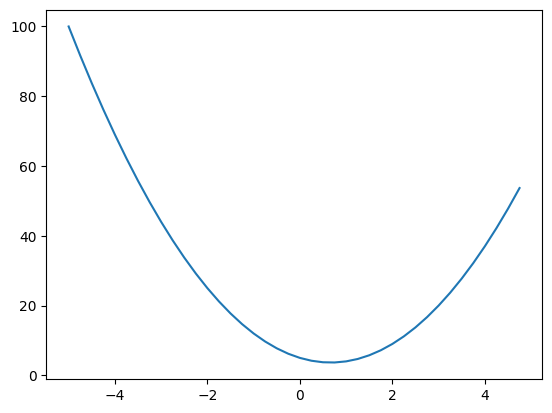

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
print(ys)
plt.plot(xs, ys)

In [12]:
# using the definition of derivatives
h = 0.000001
x = 3.0
(f(x+h) - f(x)) / h

14.000003002223593

In [15]:
# finding derivative of d wrt a
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
d2 = a*b + c
print("d1: ", d1, "d2: ", d2)
print("slope: ", (d2-d1)/h)

d1:  4.0 d2:  3.999699999999999
slope:  -3.000000000010772


In [13]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    # so that we can use oprn like a+1
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    # as in addn derivative of out wrt self = 1 and same for other
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __neg__(self):
    return self * -1
  
  def __sub__(self, other):
    return self + (-other)
  
  def __rmul__(self, other):  # for other * self like (2 * a)
    return self * other
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only int and float powers"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      # we are mul with out.grad so as to follow chain rule
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward

    return out
  
  def __truediv__(self, other):
    return self * other**-1
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [15]:
a = Value(2.0)
# 2*a
b = Value(4.0)
# a / b = a * (b**-1)
-a

Value(data=-2.0)

In [14]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in graph, create a node for it
    dot.node(name = uid, label = "{ %s |  data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if value came from a operation, create op node for it
      dot.node(name = uid + n._op, label = n._op)
      # connect the node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

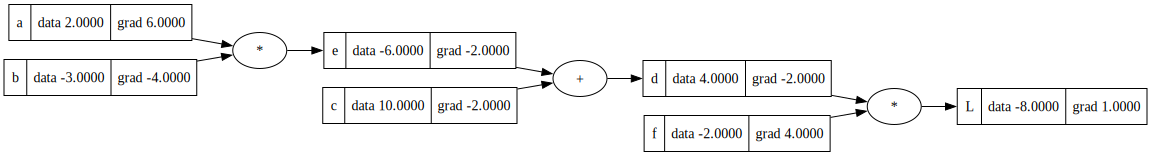

In [9]:
draw_dot(L)

In [ ]:
# manual back-prop 1
L.grad = 1.0
# dL/dd = f and dL/df = d
f.grad = 4.0
d.grad = -2.0
# dL/dc = dL/dd * dd/dc 
c.grad = -2.0
e.grad = -2.0
# dL/da = dL/de * de/da
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [ ]:
# to increase L we go in dirn of gradient at leaf nodes
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad
e = a*b
d = e + c
L = d * f

print(L.data)

-7.286496


In [ ]:
# to check gradient correctness
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  d.data += h
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

lol()

-2.000000000000668


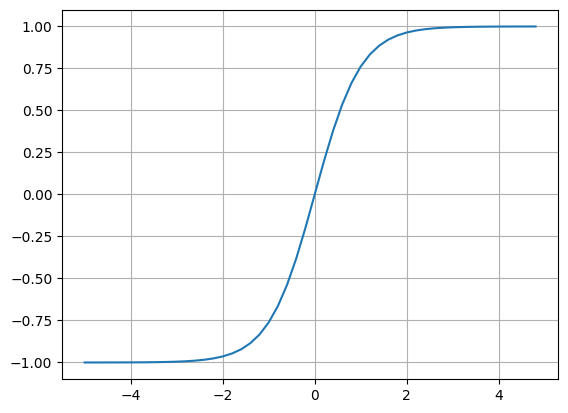

In [10]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid(); 

In [15]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'

# o = n.tanh(); o.label='o'
e = (2*n).exp()
o = (e-1) / (e+1); o.label='o'

o.backward()

In [ ]:
# back-prop using the _fn., but initialize last node by 1.0
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

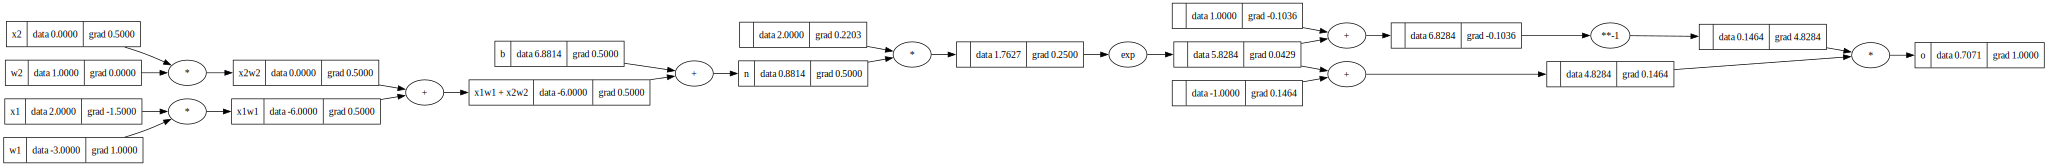

In [16]:
draw_dot(o)

we need to find everything after the node, before we go backward from it, so we use: 
## topological sort

In [55]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

print(topo)

for node in reversed(topo):
  node._backward()

[Value(data=6.881373587019543), Value(data=2.0), Value(data=-3.0), Value(data=-6.0), Value(data=1.0), Value(data=0.0), Value(data=0.0), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


In [ ]:
# manual pass

o.grad = 1.0
# o = tanh(n), do/dn = 1 - o**2
n.grad = 1 - o.data**2
# as '+' symbol so grad flows on
x1w1x2w2.grad = 0.5; b.grad = 0.5
x1w1.grad = 0.5; x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

## Issue when we use a variable more than once
so solution is that we accumulate these gradients (using multivariable case)

so using += when backward-propagating

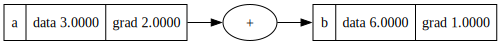

In [65]:
# bug example
a = Value(3.0, label='a')
b = a+a; b.label='b'
b.backward()
draw_dot(b)

In [1]:
import torch

In [4]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [2]:
torch.Tensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [8]:
import random

In [27]:
class Neuron:
  def __init__(self, nin):
    # nin = no. of inputs to that neuron
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w*x + b
    # zip -> gives a 'w' to a 'x'
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
# has many Neurons
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
# Multi Layer Perceptron (has many layers)
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    # no. of layers = len of nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


In [ ]:
# x = [2.0, 3.0]
# n = Neuron(2)
# n(x)

# x = [2.0, 3.0]
# n = Layer(2, 3)
# n(x)

In [38]:
x = [2.0, 3.0, -1.0]
# nouts -> no. of neurons in each layer
# str. -> 3 I/P, hidden layer 1 -> 4N, hidden layer 2 -> 4N and 1 O/P
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6725652561053351)

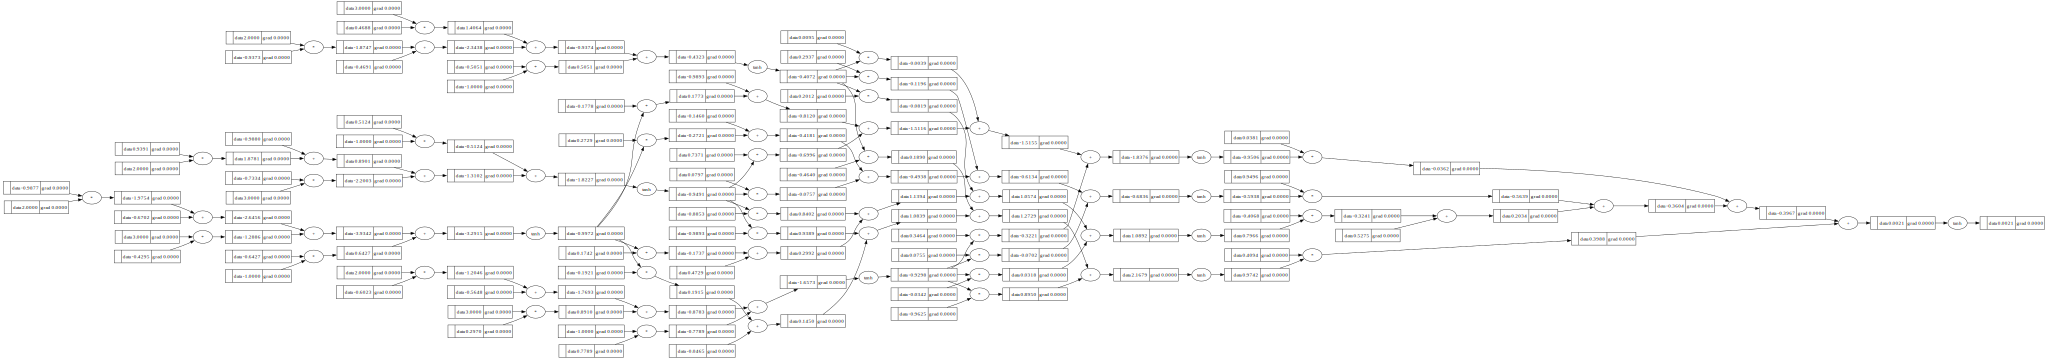

In [34]:
draw_dot(n(x))

In [36]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0], 
  [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired O/P

ypred = [n(x) for x in xs]
ypred

[Value(data=0.0020889040163418623),
 Value(data=0.38232975655257306),
 Value(data=-0.008958264008285031),
 Value(data=0.031234784433778782)]

In [42]:
loss = sum(([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]), Value(0.0))
loss

Value(data=4.82733187670654)